In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices
!nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
!lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
!free -h --si | awk  '/Mem:/{print $2}'

# if use tpu
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

/bin/bash: /tmp/ENTER/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Thu Nov  3 13:28:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:2D:00.0 Off |                  Off |
| 30%   31C    P8    26W / 230W |     22MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=28)
mpl.rc('xtick', labelsize=24)
mpl.rc('ytick', labelsize=24)

import math
import time 
# from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

2022-11-03 13:28:12.495621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 13:28:12.594864: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-03 13:28:12.623472: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 13:28:13.124358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
print(is_gpu)

True


# CFD Parameters

In [18]:
dt = 0.5
dx = 1.0
dy = 1.0
dz = 1.0
Re = 1/20
ub = 1
nx = 4096
ny = 4096
nz = 256
ratio = int(nx/nz)
nlevel = int(math.log(nz, 2)) + 1 
print('Levels of Multigrid:', nlevel)
print('Aspect ratio of Domain:', ratio)

Levels of Multigrid: 9
Aspect ratio of Domain: 16


# Weights of CNNs layers

In [6]:
pd1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pd2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pd3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w1 = np.zeros([1,3,3,3,1])
w1[0,0,:,:,0] = np.array(pd1)*dt*Re/dx**2
w1[0,1,:,:,0] = np.array(pd2)*dt*Re/dx**2 
w1[0,2,:,:,0] = np.array(pd3)*dt*Re/dx**2 

In [7]:
p_div_x1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w2 = np.zeros([1,3,3,3,1])
w3 = np.zeros([1,3,3,3,1])
w4 = np.zeros([1,3,3,3,1])

w2[0,0,:,:,0] = np.array(p_div_x1)*dt/dx*0.5
w2[0,1,:,:,0] = np.array(p_div_x2)*dt/dx*0.5
w2[0,2,:,:,0] = np.array(p_div_x3)*dt/dx*0.5

w3[0,0,:,:,0] = np.array(p_div_y1)*dt/dx*0.5
w3[0,1,:,:,0] = np.array(p_div_y2)*dt/dx*0.5
w3[0,2,:,:,0] = np.array(p_div_y3)*dt/dx*0.5 

w4[0,0,:,:,0] = np.array(p_div_z1)*dt/dx*0.5 
w4[0,1,:,:,0] = np.array(p_div_z2)*dt/dx*0.5
w4[0,2,:,:,0] = np.array(p_div_z3)*dt/dx*0.5

In [8]:
pA1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pA2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pA3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w5 = np.zeros([1,3,3,3,1])
w5[0,0,:,:,0] = -np.array(pA1)/dx**2
w5[0,1,:,:,0] = -np.array(pA2)/dx**2 
w5[0,2,:,:,0] = -np.array(pA3)/dx**2 

In [9]:
pctyu1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
pctyu2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
pctyu3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

pctyv1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
pctyv2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
pctyv3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

pctyw1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
pctyw2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
pctyw3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w6 = np.zeros([1,3,3,3,1])
w7 = np.zeros([1,3,3,3,1])
w8 = np.zeros([1,3,3,3,1])
w9 = np.zeros([1,2,2,2,1])
w6[0,0,:,:,0] = np.array(pctyu1)/(dx*dt)*0.5
w6[0,1,:,:,0] = np.array(pctyu2)/(dx*dt)*0.5
w6[0,2,:,:,0] = np.array(pctyu3)/(dx*dt)*0.5
w7[0,0,:,:,0] = np.array(pctyv1)/(dx*dt)*0.5
w7[0,1,:,:,0] = np.array(pctyv2)/(dx*dt)*0.5
w7[0,2,:,:,0] = np.array(pctyv3)/(dx*dt)*0.5 
w8[0,0,:,:,0] = np.array(pctyw1)/(dx*dt)*0.5
w8[0,1,:,:,0] = np.array(pctyw2)/(dx*dt)*0.5
w8[0,2,:,:,0] = np.array(pctyw3)/(dx*dt)*0.5
w9[0,:,:,:,0] = 0.125

In [10]:
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
kernel_initializer_8 = tf.keras.initializers.constant(w8)
kernel_initializer_9 = tf.keras.initializers.constant(w9)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# Libraries for solving momentum equation

In [11]:
CNN3D_central_2nd_dif = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_xadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_yadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_zadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer),
])

CNN3D_Su = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_6,
                                bias_initializer=bias_initializer),
])

CNN3D_Sv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_7,
                                bias_initializer=bias_initializer),
])

CNN3D_Sw = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_8,
                                bias_initializer=bias_initializer),
])


2022-11-03 13:28:34.525052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 13:28:34.565581: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x686d830 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-03 13:28:34.565611: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2022-11-03 13:28:35.098296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:2d:00.0, compute capability: 8.6
2022-11-03 13:28:35.100376: I tensorflow/compiler/xla/service/ser

# Libraries for multigrid algorithms

In [12]:
for i in range(nlevel):
    locals()['CNN3D_A_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-1-i)), int(ny*0.5**(nlevel-1-i)), int(nx*0.5**(nlevel-1-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer)
    ])

In [13]:
for i in range(nlevel-1):
    locals()['CNN3D_res_'+str(2**(i+1))] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-2-i)), int(ny*0.5**(nlevel-2-i)), int(nx*0.5**(nlevel-2-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),   
    ])    

In [14]:
for i in range(nlevel-1):
    locals()['CNN3D_prol_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1*2**i, 1*ratio*2**i, 1*ratio*2**i, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
    ])

# Functions linking to the AI libraries

In [15]:
def boundary_condition_velocity(values_u,values_v,values_w):
    'Define boundary conditions for velocity field'
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempw = tf.Variable(values_w) 
    tempu[0,:,:,0,0].assign(tf.Variable(tf.ones((1,nz,ny)))[0,:]*ub) 
    tempv[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])    
    tempw[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])    

    tempu[0,:,:,nx-1,0].assign(tf.Variable(tf.ones((1,nz,ny)))[0,:]*ub) 
    tempv[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])   
    tempw[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])  
    
    tempu[0,:,0,:,0].assign(tf.Variable(values_u)[0,:,1,:,0])     
    tempv[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])  
    tempw[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])  
        
    tempu[0,:,nx-1,:,0].assign(tf.Variable(values_u)[0,:,nx-2,:,0])      
    tempv[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])     
    tempw[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nz,nx)))[0,:])  
    
    tempu[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])     
    tempv[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])  
    tempw[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])  
        
    tempu[0,nz-1,:,:,0].assign(tf.Variable(values_u)[0,nz-2,:,:,0])      
    tempv[0,nz-1,:,:,0].assign(tf.Variable(values_v)[0,nz-2,:,:,0])     
    tempw[0,nz-1,:,:,0].assign(tf.Variable(tf.zeros((1,ny,nx)))[0,:])      
    return tempu,tempv,tempw

def boundary_condition_pressure(values_p,nx):
    'Define boundary conditions for pressure field'
    tempp = tf.Variable(values_p)   
    tempp[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:]) 
    tempp[0,:,:,0,0].assign(tf.Variable(values_p)[0,:,:,1,0])
    
    tempp[0,:,0,:,0].assign(tf.Variable(values_p)[0,:,1,:,0])     
    tempp[0,:,nx-1,:,0].assign(tf.Variable(values_p)[0,:,nx-2,:,0]) 
    
    tempp[0,0,:,:,0].assign(tf.Variable(values_p)[0,1,:,:,0])     
    tempp[0,nz-1,:,:,0].assign(tf.Variable(values_p)[0,nz-2,:,:,0])  
    return tempp

def boundary_condition_indicator(alpha,nx):   
    'Define boundary conditions for scalar field'
    tempa = tf.Variable(alpha)   
    tempa[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempa[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])
    
    tempa[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    
    tempa[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    return tempa

def boundary_condition_source(b,nx):  
    'Define inflow boundary conditions for source terms to'
    'avoid incorrect paddings caused by CNNs'
    tempb = tf.Variable(b)   
    tempb[0,:,:,0,0].assign(tf.Variable(b)[0,:,:,1,0])
    return tempb

def bluff_body(values_u,values_v,values_w,sigma):
    'Immersed Boundary for buildings'
    temp1 = values_u / (1+dt*sigma) 
    temp2 = values_v / (1+dt*sigma)
    temp3 = values_w / (1+dt*sigma) 
    return temp1,temp2,temp3

def save_data(n_out,itime):
    'Save field data'
    if itime % n_out == 0:  
        np.save("data_SK_Petrov_Galerkin_demo/uu"+str(itime), arr=values_u[0,:,:,:,0])
        np.save("data_SK_Petrov_Galerkin_demo/vv"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("data_SK_Petrov_Galerkin_demo/ww"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("data_SK_Petrov_Galerkin_demo/pp"+str(itime), arr=values_p[0,:,:,:,0])

In [17]:
def Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_x: Final diffusion matrix in x direction 
    k_y: Final diffusion matrix in y direction 
    k_z: Final diffusion matrix in z direction 
    '''
    values_u = values_u / (1+dt*sigma) 
    values_v = values_v / (1+dt*sigma)     
    values_w = values_w / (1+dt*sigma) 
      
    k_u = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               CNN3D_central_2nd_dif(values_u)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_u)) + 
                               abs(CNN3D_central_2nd_yadv(values_u)) + 
                               abs(CNN3D_central_2nd_zadv(values_u)))/3)
    
    k_v = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               CNN3D_central_2nd_dif(values_v)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_v)) + 
                               abs(CNN3D_central_2nd_yadv(values_v)) + 
                               abs(CNN3D_central_2nd_zadv(values_v)))/3)
    
    k_w = 8 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               CNN3D_central_2nd_dif(values_w)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_w)) + 
                               abs(CNN3D_central_2nd_yadv(values_w)) + 
                               abs(CNN3D_central_2nd_zadv(values_w)))/3)
       
    k_u = tf.math.minimum(k_u, tf.ones(input_shape)*0.5) / (1+dt*sigma) 
    k_v = tf.math.minimum(k_v, tf.ones(input_shape)*0.5) / (1+dt*sigma)     
    k_w = tf.math.minimum(k_w, tf.ones(input_shape)*0.5) / (1+dt*sigma)    
    
    
    k_x = 3*0.5*(k_u*CNN3D_central_2nd_dif(values_u) +
                CNN3D_central_2nd_dif(values_u*k_u) -
                values_u*CNN3D_central_2nd_dif(k_u))


    k_y = 3*0.5*(k_v*CNN3D_central_2nd_dif(values_v) + 
                CNN3D_central_2nd_dif(values_v*k_v) -
                values_v*CNN3D_central_2nd_dif(k_v))


    k_z = 3*0.5*(k_w*CNN3D_central_2nd_dif(values_w) + 
                CNN3D_central_2nd_dif(values_w*k_w) -
                values_w*CNN3D_central_2nd_dif(k_w))

    return k_x, k_y, k_z

# Initialise

============== Numerical parameters ===============
Mesh resolution: (1, 128, 1024, 1024, 1)
Time step: 4000
Initial time: 0
Solving single-phase flows!
Switch on IBM solver!


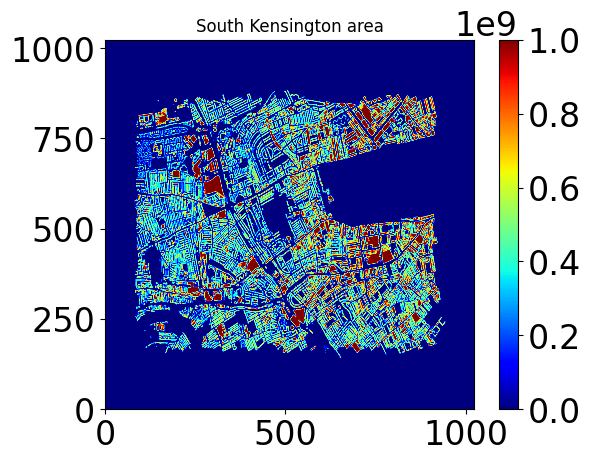

In [18]:
#################### Create field #####£###############
input_shape = (1,nz,ny,nx,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)
#######################################################
################# Numerical parameters ################
multi_itr = 5               # Iterations of multi-grid 
j_itr = 1                   # Iterations of Jacobi 
ntime = 8000                 # Time steps
n_out = 500                 # Results output
nrestart = 0                # Last time step for restart
ctime_old = 0               # Last ctime for restart
mgsolver = True             # Multigrid solver
LSCALAR = False              # Scalar transport 
LMTI = False                 # Non density for multiphase flows
LIBM = True                # Immersed boundary method 
nsafe = 0.5                 # Continuty equation residuals
ctime = 0                   # Initialise ctime   
save_fig = True             # Save results
Restart = False             # Restart
eplsion_k = 1e-03
################# Physical parameters #################
rho_l = 1000                # Density of liquid phase 
rho_g = 980                 # Density of gas phase 
g_x = 0;g_y = 0;g_z = -9.8   # Gravity acceleration (m/s2) 
#######################################################
print('============== Numerical parameters ===============')
print('Mesh resolution:', values_v.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
#######################################################
################# Only for restart ####################
if Restart == True:
    temp1 = np.load('data_SK/u2500.npy').astype('float32')
    temp2 = np.load('data_SK/v2500.npy').astype('float32')
    temp3 = np.load('data_SK/w2500.npy').astype('float32')
    temp4 = np.load('data_SK/p2500.npy').astype('float32')
    values_u = tf.Variable(values_u)[0,:,:,:,0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0,:,:,:,0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0,:,:,:,0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0,:,:,:,0].assign(tf.convert_to_tensor(temp4))
    nrestart = 2500
    ctime_old = nrestart*dt
    print('Restart solver!')
#######################################################    
################# Only for scalar #####################
if LSCALAR == True:
    alpha = np.zeros(input_shape).astype('float32')
    alpha[0,0:64,:,:,0] = 0
    alpha[0,64:128,:,:,0] = 1.0
    alpha = tf.convert_to_tensor(alpha)
    print('Switch on scalar filed solver!')
#######################################################
################# Only for scalar #####################
if LMTI == True:
    rho = tf.zeros(input_shape)
    rho = alpha*rho_l + (1-alpha)*rho_g
    print('Solving multiphase flows!')
else:
    rho = tf.ones(input_shape)
    print('Solving single-phase flows!')
################# Only for IBM ########################
if LIBM == True:
    mesh = np.load('INHALE_1280.npy')
    sigma = np.zeros(input_shape).astype('float32')
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            for k in range(1,nz-1):
                if mesh[0][i][j][k][0] == 0:
                    sigma[0][k][j][i][0] = 1000000000  
    sigma = tf.convert_to_tensor(sigma)
    print('Switch on IBM solver!')
    print('===================================================')
    plt.imshow(sigma[0,1,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('South Kensington area')
    plt.gca().invert_yaxis()
#######################################################

# AI-HFM Solver

In [20]:
start = time.time()
for itime in range(1,ntime+1): 
    ctime = ctime + dt 
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
    values_p = boundary_condition_pressure(values_p,nx)
# Petrov-Galerkin dissipation
    [k_x,k_y,k_z] = Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma)
# Momentum equation 
    a_u = k_x - \
    values_u*CNN3D_central_2nd_xadv(values_u) - \
    values_v*CNN3D_central_2nd_yadv(values_u) - \
    values_w*CNN3D_central_2nd_zadv(values_u)
    b_u = 0.5*a_u + values_u
    a_v = k_y - \
    values_u*CNN3D_central_2nd_xadv(values_v) - \
    values_v*CNN3D_central_2nd_yadv(values_v) - \
    values_w*CNN3D_central_2nd_zadv(values_v)
    b_v = 0.5*a_v + values_v
    a_w = k_z - \
    values_u*CNN3D_central_2nd_xadv(values_w) - \
    values_v*CNN3D_central_2nd_yadv(values_w) - \
    values_w*CNN3D_central_2nd_zadv(values_w) 
    b_w = 0.5*a_w + values_w

    [b_u,b_v,b_w] = boundary_condition_velocity(b_u,b_v,b_w)
    [kb_x,kb_y,kb_z] = Petrov_Galerkin_dissipation(b_u, b_v, b_w, eplsion_k, sigma)

    c_u = kb_x - \
    b_u*CNN3D_central_2nd_xadv(b_u) - \
    b_v*CNN3D_central_2nd_yadv(b_u) - \
    b_w*CNN3D_central_2nd_zadv(b_u)
    values_u = values_u + c_u      
    c_v = kb_y - \
    b_u*CNN3D_central_2nd_xadv(b_v) - \
    b_v*CNN3D_central_2nd_yadv(b_v) - \
    b_w*CNN3D_central_2nd_zadv(b_v) 
    values_v = values_v + c_v
    c_w = kb_z - \
    b_u*CNN3D_central_2nd_xadv(b_w) - \
    b_v*CNN3D_central_2nd_yadv(b_w) - \
    b_w*CNN3D_central_2nd_zadv(b_w) 
    values_w = values_w + c_w    
# Passive tracer scalar transport
    if LSCALAR == True:
        a_t = CNN3D_central_2nd_dif(alpha) - \
        values_u*CNN3D_central_2nd_xadv(alpha) - \
        values_v*CNN3D_central_2nd_yadv(alpha) - \
        values_w*CNN3D_central_2nd_zadv(alpha)
        alpha = alpha + a_t
        alpha = boundary_condition_indicator(alpha,nx)
    if LMTI == True:
        rho = alpha*rho_l + (1-alpha)*rho_g
# IBM
#     if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# gradp            
    values_u = values_u - CNN3D_central_2nd_xadv(values_p)
    values_v = values_v - CNN3D_central_2nd_yadv(values_p)  
    values_w = values_w - CNN3D_central_2nd_zadv(values_p)     
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
# possion equation (multi-grid) A*P = Su
    b = -(CNN3D_Su(values_u) + CNN3D_Sv(values_v) + CNN3D_Sw(values_w))
    b = boundary_condition_source(b,nx)
    if mgsolver == True:
        for multi_grid in range(multi_itr): 
            w_1 = tf.zeros([1,1,ratio,ratio,1])
            r = CNN3D_A_256(values_p) - b   
            r = tf.Variable(r)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:]) 
#             r_256 = CNN3D_res_512(r) 
            r_128 = CNN3D_res_256(r) 
            r_64 = CNN3D_res_128(r_128) 
            r_32 = CNN3D_res_64(r_64) 
            r_16 = CNN3D_res_32(r_32) 
            r_8 = CNN3D_res_16(r_16) 
            r_4 = CNN3D_res_8(r_8) 
            r_2 = CNN3D_res_4(r_4) 
            r_1 = CNN3D_res_2(r_2)
            for Jacobi in range(j_itr):
                w_1 = (w_1 - CNN3D_A_1(w_1)/w5[0,1,1,1,0] + r_1/w5[0,1,1,1,0])
            w_2 = CNN3D_prol_1(w_1)             
            for Jacobi in range(j_itr):
                w_2 = (w_2 - CNN3D_A_2(w_2)/w5[0,1,1,1,0] + r_2/w5[0,1,1,1,0])
            w_4 = CNN3D_prol_2(w_2) 
            for Jacobi in range(j_itr):
                w_4 = (w_4 - CNN3D_A_4(w_4)/w5[0,1,1,1,0] + r_4/w5[0,1,1,1,0])
            w_8 = CNN3D_prol_4(w_4) 
            for Jacobi in range(j_itr):
                w_8 = (w_8 - CNN3D_A_8(w_8)/w5[0,1,1,1,0] + r_8/w5[0,1,1,1,0])
            w_16 = CNN3D_prol_8(w_8) 
            for Jacobi in range(j_itr):
                w_16 = (w_16 - CNN3D_A_16(w_16)/w5[0,1,1,1,0] + r_16/w5[0,1,1,1,0])
            w_32 = CNN3D_prol_16(w_16) 
            for Jacobi in range(j_itr):
                w_32 = (w_32 - CNN3D_A_32(w_32)/w5[0,1,1,1,0] + r_32/w5[0,1,1,1,0])
            w_64 = CNN3D_prol_32(w_32) 
            for Jacobi in range(j_itr):
                w_64 = (w_64 - CNN3D_A_64(w_64)/w5[0,1,1,1,0] + r_64/w5[0,1,1,1,0])
            w_128 = CNN3D_prol_64(w_64) 
            for Jacobi in range(j_itr):
                w_128 = (w_128 - CNN3D_A_128(w_128)/w5[0,1,1,1,0] + r_128/w5[0,1,1,1,0] )
            w_256 = CNN3D_prol_128(w_128)
#             for Jacobi in range(j_itr):
#                 w_256 = (w_256 - CNN3D_A_256(w_256)/w5[0,1,1,1,0] + r_256/w5[0,1,1,1,0] )
#             w_512 = CNN3D_prol_256(w_256)
            values_p = values_p - w_256
            values_p = tf.Variable(values_p)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])         
            values_p = (values_p - CNN3D_A_256(values_p)/w5[0,1,1,1,0] + b/w5[0,1,1,1,0])          
# correct
    values_p = boundary_condition_pressure(values_p,nx)
    values_u = values_u - CNN3D_central_2nd_xadv(values_p)
    values_v = values_v - CNN3D_central_2nd_yadv(values_p)  
    values_w = values_w - CNN3D_central_2nd_zadv(values_p)      
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
#     if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# output   
    print('Time step:', itime) 
    print('Pressure error:', np.max(w_256), 'cty equation residual:', np.max(r))
    print('========================================================')
    if np.max(np.abs(w_256)) > nsafe:
        print('Not converged !!!!!!')
        break
    if save_fig == True:
        save_data(n_out,itime+nrestart)
end = time.time()
print('time',(end-start))

Time step: 1
Pressure error: 0.005205096 cty equation residual: 0.031620383
Time step: 2
Pressure error: 0.0052013006 cty equation residual: 0.031602487
Time step: 3
Pressure error: 0.0051975045 cty equation residual: 0.0315845
Time step: 4
Pressure error: 0.005193702 cty equation residual: 0.031566575
Time step: 5
Pressure error: 0.0051899063 cty equation residual: 0.03154877
Time step: 6
Pressure error: 0.005186093 cty equation residual: 0.03153099
Time step: 7
Pressure error: 0.0051822835 cty equation residual: 0.031513333
Time step: 8
Pressure error: 0.0051784636 cty equation residual: 0.031495363
Time step: 9
Pressure error: 0.005174648 cty equation residual: 0.031477645
Time step: 10
Pressure error: 0.0051708254 cty equation residual: 0.03145966
Time step: 11
Pressure error: 0.0051670047 cty equation residual: 0.031441733
Time step: 12
Pressure error: 0.0051631876 cty equation residual: 0.03142388
Time step: 13
Pressure error: 0.0051593846 cty equation residual: 0.031406015
Time 

Pressure error: 0.00496795 cty equation residual: 0.030497909
Time step: 63
Pressure error: 0.004963943 cty equation residual: 0.03047879
Time step: 64
Pressure error: 0.004959943 cty equation residual: 0.030459702
Time step: 65
Pressure error: 0.0049559395 cty equation residual: 0.030440643
Time step: 66
Pressure error: 0.0049519297 cty equation residual: 0.030421525
Time step: 67
Pressure error: 0.0049479133 cty equation residual: 0.030402333
Time step: 68
Pressure error: 0.004943894 cty equation residual: 0.030383155
Time step: 69
Pressure error: 0.0049398765 cty equation residual: 0.030363917
Time step: 70
Pressure error: 0.0049358574 cty equation residual: 0.030344754
Time step: 71
Pressure error: 0.0049318396 cty equation residual: 0.030325532
Time step: 72
Pressure error: 0.0049278094 cty equation residual: 0.03030625
Time step: 73
Pressure error: 0.0049237916 cty equation residual: 0.030287027
Time step: 74
Pressure error: 0.004919756 cty equation residual: 0.030267656
Time ste

Time step: 123
Pressure error: 0.004723787 cty equation residual: 0.029323548
Time step: 124
Pressure error: 0.00471984 cty equation residual: 0.02930446
Time step: 125
Pressure error: 0.004715885 cty equation residual: 0.029285505
Time step: 126
Pressure error: 0.0047119427 cty equation residual: 0.029266521
Time step: 127
Pressure error: 0.0047079944 cty equation residual: 0.029247507
Time step: 128
Pressure error: 0.0047040526 cty equation residual: 0.029228508
Time step: 129
Pressure error: 0.0047001303 cty equation residual: 0.029209688
Time step: 130
Pressure error: 0.004696192 cty equation residual: 0.029190645
Time step: 131
Pressure error: 0.004692266 cty equation residual: 0.029171795
Time step: 132
Pressure error: 0.0046883347 cty equation residual: 0.029152855
Time step: 133
Pressure error: 0.004684412 cty equation residual: 0.02913785
Time step: 134
Pressure error: 0.0046804934 cty equation residual: 0.02912578
Time step: 135
Pressure error: 0.0046765823 cty equation resid

Time step: 184
Pressure error: 0.004491649 cty equation residual: 0.028544828
Time step: 185
Pressure error: 0.0044880277 cty equation residual: 0.028533712
Time step: 186
Pressure error: 0.0044844155 cty equation residual: 0.028522491
Time step: 187
Pressure error: 0.0044808057 cty equation residual: 0.02851133
Time step: 188
Pressure error: 0.0044772127 cty equation residual: 0.028500348
Time step: 189
Pressure error: 0.004473627 cty equation residual: 0.028489202
Time step: 190
Pressure error: 0.004470035 cty equation residual: 0.028478086
Time step: 191
Pressure error: 0.0044664494 cty equation residual: 0.028467134
Time step: 192
Pressure error: 0.0044628805 cty equation residual: 0.028456166
Time step: 193
Pressure error: 0.0044593127 cty equation residual: 0.02844511
Time step: 194
Pressure error: 0.0044557503 cty equation residual: 0.028434157
Time step: 195
Pressure error: 0.0044522025 cty equation residual: 0.028423205
Time step: 196
Pressure error: 0.0044486457 cty equation 

Time step: 245
Pressure error: 0.0042838715 cty equation residual: 0.027899638
Time step: 246
Pressure error: 0.0042806705 cty equation residual: 0.027889594
Time step: 247
Pressure error: 0.004277456 cty equation residual: 0.027879432
Time step: 248
Pressure error: 0.004274262 cty equation residual: 0.027869388
Time step: 249
Pressure error: 0.0042710598 cty equation residual: 0.027859345
Time step: 250
Pressure error: 0.0042678625 cty equation residual: 0.027849227
Time step: 251
Pressure error: 0.0042646765 cty equation residual: 0.027839154
Time step: 252
Pressure error: 0.00426149 cty equation residual: 0.027829126
Time step: 253
Pressure error: 0.004258309 cty equation residual: 0.027819067
Time step: 254
Pressure error: 0.0042551244 cty equation residual: 0.027809039
Time step: 255
Pressure error: 0.004251955 cty equation residual: 0.027799025
Time step: 256
Pressure error: 0.004248785 cty equation residual: 0.027789012
Time step: 257
Pressure error: 0.0042456104 cty equation re

Time step: 306
Pressure error: 0.0040889042 cty equation residual: 0.027281314
Time step: 307
Pressure error: 0.0040855594 cty equation residual: 0.027270705
Time step: 308
Pressure error: 0.004082214 cty equation residual: 0.027259916
Time step: 309
Pressure error: 0.004078846 cty equation residual: 0.027249247
Time step: 310
Pressure error: 0.0040754755 cty equation residual: 0.027238563
Time step: 311
Pressure error: 0.0040720943 cty equation residual: 0.0272277
Time step: 312
Pressure error: 0.0040686997 cty equation residual: 0.027216747
Time step: 313
Pressure error: 0.0040653725 cty equation residual: 0.027205944
Time step: 314
Pressure error: 0.004062058 cty equation residual: 0.027195096
Time step: 315
Pressure error: 0.0040587387 cty equation residual: 0.027184263
Time step: 316
Pressure error: 0.0040554046 cty equation residual: 0.027173534
Time step: 317
Pressure error: 0.0040520546 cty equation residual: 0.027162716
Time step: 318
Pressure error: 0.004048691 cty equation r

Time step: 367
Pressure error: 0.0039658006 cty equation residual: 0.026804954
Time step: 368
Pressure error: 0.0039684307 cty equation residual: 0.026812151
Time step: 369
Pressure error: 0.003970878 cty equation residual: 0.026818767
Time step: 370
Pressure error: 0.003973361 cty equation residual: 0.026824772
Time step: 371
Pressure error: 0.0039756456 cty equation residual: 0.026830077
Time step: 372
Pressure error: 0.003977731 cty equation residual: 0.026834726
Time step: 373
Pressure error: 0.003979628 cty equation residual: 0.026838616
Time step: 374
Pressure error: 0.003981311 cty equation residual: 0.026842386
Time step: 375
Pressure error: 0.0039827796 cty equation residual: 0.026845485
Time step: 376
Pressure error: 0.003984039 cty equation residual: 0.026847988
Time step: 377
Pressure error: 0.003985069 cty equation residual: 0.026849777
Time step: 378
Pressure error: 0.00398589 cty equation residual: 0.026850805
Time step: 379
Pressure error: 0.0039864695 cty equation resi

Time step: 428
Pressure error: 0.0038206284 cty equation residual: 0.026098773
Time step: 429
Pressure error: 0.0038167357 cty equation residual: 0.026074931
Time step: 430
Pressure error: 0.0038127785 cty equation residual: 0.026050791
Time step: 431
Pressure error: 0.0038087578 cty equation residual: 0.026026294
Time step: 432
Pressure error: 0.0038046672 cty equation residual: 0.0260012
Time step: 433
Pressure error: 0.0038005193 cty equation residual: 0.025975868
Time step: 434
Pressure error: 0.003796302 cty equation residual: 0.02594997
Time step: 435
Pressure error: 0.0037920205 cty equation residual: 0.025923654
Time step: 436
Pressure error: 0.0037876745 cty equation residual: 0.025896981
Time step: 437
Pressure error: 0.0037832602 cty equation residual: 0.025869787
Time step: 438
Pressure error: 0.0037787755 cty equation residual: 0.025842175
Time step: 439
Pressure error: 0.0037742252 cty equation residual: 0.025814041
Time step: 440
Pressure error: 0.003769606 cty equation 

Time step: 489
Pressure error: 0.0036384824 cty equation residual: 0.02492708
Time step: 490
Pressure error: 0.003636673 cty equation residual: 0.024914995
Time step: 491
Pressure error: 0.0036348703 cty equation residual: 0.02490297
Time step: 492
Pressure error: 0.003633068 cty equation residual: 0.024891034
Time step: 493
Pressure error: 0.0036312835 cty equation residual: 0.024879128
Time step: 494
Pressure error: 0.0036295038 cty equation residual: 0.024867326
Time step: 495
Pressure error: 0.0036277275 cty equation residual: 0.024855554
Time step: 496
Pressure error: 0.0036259594 cty equation residual: 0.024843723
Time step: 497
Pressure error: 0.0036241938 cty equation residual: 0.02483204
Time step: 498
Pressure error: 0.0036224432 cty equation residual: 0.024820387
Time step: 499
Pressure error: 0.0036206935 cty equation residual: 0.02480872
Time step: 500
Pressure error: 0.0036189575 cty equation residual: 0.024797231
Time step: 501
Pressure error: 0.0036172208 cty equation r

Time step: 550
Pressure error: 0.0035415872 cty equation residual: 0.024282232
Time step: 551
Pressure error: 0.003540235 cty equation residual: 0.024273261
Time step: 552
Pressure error: 0.0035388866 cty equation residual: 0.024264216
Time step: 553
Pressure error: 0.0035375447 cty equation residual: 0.02425526
Time step: 554
Pressure error: 0.0035362123 cty equation residual: 0.024246365
Time step: 555
Pressure error: 0.0035348805 cty equation residual: 0.02423741
Time step: 556
Pressure error: 0.003533563 cty equation residual: 0.024228677
Time step: 557
Pressure error: 0.00353225 cty equation residual: 0.024219915
Time step: 558
Pressure error: 0.003530942 cty equation residual: 0.024211168
Time step: 559
Pressure error: 0.0035296415 cty equation residual: 0.024202406
Time step: 560
Pressure error: 0.0035283505 cty equation residual: 0.024193928
Time step: 561
Pressure error: 0.0035270662 cty equation residual: 0.024185374
Time step: 562
Pressure error: 0.0035257926 cty equation re

Time step: 611
Pressure error: 0.003482062 cty equation residual: 0.023871168
Time step: 612
Pressure error: 0.0034815068 cty equation residual: 0.023868397
Time step: 613
Pressure error: 0.003480948 cty equation residual: 0.023865864
Time step: 614
Pressure error: 0.003480392 cty equation residual: 0.023863241
Time step: 615
Pressure error: 0.003479971 cty equation residual: 0.023860723
Time step: 616
Pressure error: 0.0034796926 cty equation residual: 0.023858145
Time step: 617
Pressure error: 0.0034794135 cty equation residual: 0.023855567
Time step: 618
Pressure error: 0.0034791362 cty equation residual: 0.023853123
Time step: 619
Pressure error: 0.003478859 cty equation residual: 0.02385062
Time step: 620
Pressure error: 0.0034785818 cty equation residual: 0.023848027
Time step: 621
Pressure error: 0.0034783045 cty equation residual: 0.023845509
Time step: 622
Pressure error: 0.0034780283 cty equation residual: 0.02384378
Time step: 623
Pressure error: 0.003477747 cty equation res

Time step: 672
Pressure error: 0.0035843547 cty equation residual: 0.025353402
Time step: 673
Pressure error: 0.0035846052 cty equation residual: 0.025345758
Time step: 674
Pressure error: 0.0035842927 cty equation residual: 0.025334
Time step: 675
Pressure error: 0.0035834461 cty equation residual: 0.025318295
Time step: 676
Pressure error: 0.003582062 cty equation residual: 0.02529876
Time step: 677
Pressure error: 0.0035801907 cty equation residual: 0.025275663
Time step: 678
Pressure error: 0.0035778612 cty equation residual: 0.025249273
Time step: 679
Pressure error: 0.0035751238 cty equation residual: 0.0252202
Time step: 680
Pressure error: 0.0035720153 cty equation residual: 0.02518861
Time step: 681
Pressure error: 0.0035685634 cty equation residual: 0.025154695
Time step: 682
Pressure error: 0.0035648043 cty equation residual: 0.025118634
Time step: 683
Pressure error: 0.0035607985 cty equation residual: 0.025081128
Time step: 684
Pressure error: 0.0035565412 cty equation res

Time step: 733
Pressure error: 0.0034137385 cty equation residual: 0.023395076
Time step: 734
Pressure error: 0.0034161333 cty equation residual: 0.023414
Time step: 735
Pressure error: 0.003418448 cty equation residual: 0.023432449
Time step: 736
Pressure error: 0.0034206766 cty equation residual: 0.0234503
Time step: 737
Pressure error: 0.003422807 cty equation residual: 0.023467556
Time step: 738
Pressure error: 0.0034248547 cty equation residual: 0.023484185
Time step: 739
Pressure error: 0.0034268042 cty equation residual: 0.023500249
Time step: 740
Pressure error: 0.0034286682 cty equation residual: 0.02351579
Time step: 741
Pressure error: 0.0034304296 cty equation residual: 0.023530424
Time step: 742
Pressure error: 0.0034320978 cty equation residual: 0.02354461
Time step: 743
Pressure error: 0.0034336653 cty equation residual: 0.023558006
Time step: 744
Pressure error: 0.0034351337 cty equation residual: 0.023570836
Time step: 745
Pressure error: 0.0034380825 cty equation resi

Time step: 794
Pressure error: 0.0034096362 cty equation residual: 0.023379758
Time step: 795
Pressure error: 0.0034055558 cty equation residual: 0.023352906
Time step: 796
Pressure error: 0.0034013037 cty equation residual: 0.023324937
Time step: 797
Pressure error: 0.0033968845 cty equation residual: 0.02333963
Time step: 798
Pressure error: 0.0033922952 cty equation residual: 0.02335444
Time step: 799
Pressure error: 0.0033936654 cty equation residual: 0.02336751
Time step: 800
Pressure error: 0.0033949104 cty equation residual: 0.02337876
Time step: 801
Pressure error: 0.0033959004 cty equation residual: 0.023388267
Time step: 802
Pressure error: 0.0033966284 cty equation residual: 0.02339603
Time step: 803
Pressure error: 0.0033970722 cty equation residual: 0.023401499
Time step: 804
Pressure error: 0.0033972347 cty equation residual: 0.02340512
Time step: 805
Pressure error: 0.0033971108 cty equation residual: 0.02340667
Time step: 806
Pressure error: 0.0033967174 cty equation re

Time step: 855
Pressure error: 0.0031962693 cty equation residual: 0.022110969
Time step: 856
Pressure error: 0.0031917442 cty equation residual: 0.022084191
Time step: 857
Pressure error: 0.0031874492 cty equation residual: 0.022057354
Time step: 858
Pressure error: 0.0031862715 cty equation residual: 0.02204074
Time step: 859
Pressure error: 0.0031850855 cty equation residual: 0.02202785
Time step: 860
Pressure error: 0.0031838599 cty equation residual: 0.022014469
Time step: 861
Pressure error: 0.0031825989 cty equation residual: 0.022001252
Time step: 862
Pressure error: 0.0031812792 cty equation residual: 0.021987528
Time step: 863
Pressure error: 0.003179914 cty equation residual: 0.021973804
Time step: 864
Pressure error: 0.0031784768 cty equation residual: 0.021959558
Time step: 865
Pressure error: 0.0031769588 cty equation residual: 0.021944895
Time step: 866
Pressure error: 0.0031753592 cty equation residual: 0.021929964
Time step: 867
Pressure error: 0.0031736577 cty equatio

Time step: 916
Pressure error: 0.003038147 cty equation residual: 0.020979643
Time step: 917
Pressure error: 0.0030351924 cty equation residual: 0.02096647
Time step: 918
Pressure error: 0.0030321104 cty equation residual: 0.0209523
Time step: 919
Pressure error: 0.0030289015 cty equation residual: 0.02093722
Time step: 920
Pressure error: 0.0030255634 cty equation residual: 0.020920962
Time step: 921
Pressure error: 0.0030221168 cty equation residual: 0.020903915
Time step: 922
Pressure error: 0.0030185594 cty equation residual: 0.020885974
Time step: 923
Pressure error: 0.0030149047 cty equation residual: 0.020867154
Time step: 924
Pressure error: 0.003011151 cty equation residual: 0.020847678
Time step: 925
Pressure error: 0.0030073181 cty equation residual: 0.020827413
Time step: 926
Pressure error: 0.0030034306 cty equation residual: 0.02080658
Time step: 927
Pressure error: 0.0029994734 cty equation residual: 0.020785317
Time step: 928
Pressure error: 0.002995456 cty equation res

Time step: 977
Pressure error: 0.0028530578 cty equation residual: 0.019718379
Time step: 978
Pressure error: 0.0028481707 cty equation residual: 0.019686058
Time step: 979
Pressure error: 0.0028431958 cty equation residual: 0.019653276
Time step: 980
Pressure error: 0.002838127 cty equation residual: 0.019619808
Time step: 981
Pressure error: 0.0028329745 cty equation residual: 0.019585803
Time step: 982
Pressure error: 0.0028277433 cty equation residual: 0.019551337
Time step: 983
Pressure error: 0.002822439 cty equation residual: 0.019516438
Time step: 984
Pressure error: 0.0028170554 cty equation residual: 0.019481048
Time step: 985
Pressure error: 0.0028116032 cty equation residual: 0.019445196
Time step: 986
Pressure error: 0.0028060817 cty equation residual: 0.019408926
Time step: 987
Pressure error: 0.0028004965 cty equation residual: 0.01937224
Time step: 988
Pressure error: 0.0027948578 cty equation residual: 0.019335166
Time step: 989
Pressure error: 0.0027891595 cty equatio

Time step: 1038
Pressure error: 0.0026642208 cty equation residual: 0.018339768
Time step: 1039
Pressure error: 0.0026607455 cty equation residual: 0.018315151
Time step: 1040
Pressure error: 0.002657154 cty equation residual: 0.0182897
Time step: 1041
Pressure error: 0.0026534419 cty equation residual: 0.018263549
Time step: 1042
Pressure error: 0.002649616 cty equation residual: 0.018236741
Time step: 1043
Pressure error: 0.0026456774 cty equation residual: 0.018209279
Time step: 1044
Pressure error: 0.0026416292 cty equation residual: 0.01818119
Time step: 1045
Pressure error: 0.002637471 cty equation residual: 0.018152371
Time step: 1046
Pressure error: 0.0026332152 cty equation residual: 0.018123582
Time step: 1047
Pressure error: 0.0026292729 cty equation residual: 0.01809889
Time step: 1048
Pressure error: 0.002625295 cty equation residual: 0.018073276
Time step: 1049
Pressure error: 0.0026211948 cty equation residual: 0.018072337
Time step: 1050
Pressure error: 0.0026169582 cty

Pressure error: 0.0025614433 cty equation residual: 0.017811313
Time step: 1099
Pressure error: 0.0025596458 cty equation residual: 0.017802134
Time step: 1100
Pressure error: 0.002557792 cty equation residual: 0.017792508
Time step: 1101
Pressure error: 0.0025558826 cty equation residual: 0.017782703
Time step: 1102
Pressure error: 0.0025539175 cty equation residual: 0.017772496
Time step: 1103
Pressure error: 0.0025518902 cty equation residual: 0.017761856
Time step: 1104
Pressure error: 0.0025498092 cty equation residual: 0.017750993
Time step: 1105
Pressure error: 0.002547664 cty equation residual: 0.017739609
Time step: 1106
Pressure error: 0.002545464 cty equation residual: 0.017727882
Time step: 1107
Pressure error: 0.0025432035 cty equation residual: 0.017715827
Time step: 1108
Pressure error: 0.0025410291 cty equation residual: 0.017703325
Time step: 1109
Pressure error: 0.0025444413 cty equation residual: 0.01769048
Time step: 1110
Pressure error: 0.002547953 cty equation res

Pressure error: 0.0027646134 cty equation residual: 0.019007564
Time step: 1159
Pressure error: 0.002768694 cty equation residual: 0.019036382
Time step: 1160
Pressure error: 0.0027726972 cty equation residual: 0.019064829
Time step: 1161
Pressure error: 0.002776625 cty equation residual: 0.019092739
Time step: 1162
Pressure error: 0.002780485 cty equation residual: 0.019120246
Time step: 1163
Pressure error: 0.0027842624 cty equation residual: 0.019147217
Time step: 1164
Pressure error: 0.0027879598 cty equation residual: 0.019173726
Time step: 1165
Pressure error: 0.002791566 cty equation residual: 0.01919967
Time step: 1166
Pressure error: 0.0027950716 cty equation residual: 0.019224957
Time step: 1167
Pressure error: 0.0027984814 cty equation residual: 0.019249529
Time step: 1168
Pressure error: 0.0028017787 cty equation residual: 0.01927334
Time step: 1169
Pressure error: 0.0028049676 cty equation residual: 0.019296497
Time step: 1170
Pressure error: 0.0028080482 cty equation resi

Time step: 1219
Pressure error: 0.0028079578 cty equation residual: 0.019413397
Time step: 1220
Pressure error: 0.002805834 cty equation residual: 0.019397393
Time step: 1221
Pressure error: 0.0028036046 cty equation residual: 0.019380659
Time step: 1222
Pressure error: 0.0028012693 cty equation residual: 0.019363299
Time step: 1223
Pressure error: 0.0027988297 cty equation residual: 0.01934509
Time step: 1224
Pressure error: 0.0027962842 cty equation residual: 0.0193263
Time step: 1225
Pressure error: 0.0027936203 cty equation residual: 0.01930651
Time step: 1226
Pressure error: 0.0027908504 cty equation residual: 0.019285992
Time step: 1227
Pressure error: 0.0027879665 cty equation residual: 0.019264683
Time step: 1228
Pressure error: 0.002784969 cty equation residual: 0.019242525
Time step: 1229
Pressure error: 0.0027818684 cty equation residual: 0.019219622
Time step: 1230
Pressure error: 0.0027786521 cty equation residual: 0.01919587
Time step: 1231
Pressure error: 0.0027753422 ct

Pressure error: 0.0025661818 cty equation residual: 0.017815337
Time step: 1280
Pressure error: 0.002560905 cty equation residual: 0.017784178
Time step: 1281
Pressure error: 0.0025555685 cty equation residual: 0.017752573
Time step: 1282
Pressure error: 0.0025501715 cty equation residual: 0.01772061
Time step: 1283
Pressure error: 0.0025447097 cty equation residual: 0.0176882
Time step: 1284
Pressure error: 0.002539189 cty equation residual: 0.017655388
Time step: 1285
Pressure error: 0.0025336053 cty equation residual: 0.017622143
Time step: 1286
Pressure error: 0.0025279613 cty equation residual: 0.017588422
Time step: 1287
Pressure error: 0.0025222525 cty equation residual: 0.017554313
Time step: 1288
Pressure error: 0.0025164727 cty equation residual: 0.017519638
Time step: 1289
Pressure error: 0.0025106252 cty equation residual: 0.017484456
Time step: 1290
Pressure error: 0.0025047082 cty equation residual: 0.017448694
Time step: 1291
Pressure error: 0.002498725 cty equation resi

Time step: 1340
Pressure error: 0.0021119239 cty equation residual: 0.014933839
Time step: 1341
Pressure error: 0.0021034018 cty equation residual: 0.014907984
Time step: 1342
Pressure error: 0.0020949729 cty equation residual: 0.014912039
Time step: 1343
Pressure error: 0.002086646 cty equation residual: 0.014916105
Time step: 1344
Pressure error: 0.0020784305 cty equation residual: 0.014920158
Time step: 1345
Pressure error: 0.0020703392 cty equation residual: 0.014924215
Time step: 1346
Pressure error: 0.002062386 cty equation residual: 0.014928278
Time step: 1347
Pressure error: 0.0020545747 cty equation residual: 0.014932331
Time step: 1348
Pressure error: 0.002046913 cty equation residual: 0.014936391
Time step: 1349
Pressure error: 0.002039414 cty equation residual: 0.014940439
Time step: 1350
Pressure error: 0.0020320802 cty equation residual: 0.0149444975
Time step: 1351
Pressure error: 0.002024923 cty equation residual: 0.0149512235
Time step: 1352
Pressure error: 0.002017943

Time step: 1400
Pressure error: 0.0018510969 cty equation residual: 0.015597849
Time step: 1401
Pressure error: 0.001848542 cty equation residual: 0.015623236
Time step: 1402
Pressure error: 0.0018459273 cty equation residual: 0.015648125
Time step: 1403
Pressure error: 0.0018432583 cty equation residual: 0.015672505
Time step: 1404
Pressure error: 0.0018405165 cty equation residual: 0.015696453
Time step: 1405
Pressure error: 0.0018465675 cty equation residual: 0.015719892
Time step: 1406
Pressure error: 0.001854038 cty equation residual: 0.015742656
Time step: 1407
Pressure error: 0.0018611755 cty equation residual: 0.01576472
Time step: 1408
Pressure error: 0.0018679439 cty equation residual: 0.015785966
Time step: 1409
Pressure error: 0.0018743332 cty equation residual: 0.0158063
Time step: 1410
Pressure error: 0.0018803123 cty equation residual: 0.01582668
Time step: 1411
Pressure error: 0.001885851 cty equation residual: 0.015846036
Time step: 1412
Pressure error: 0.0018909357 ct

Time step: 1460
Pressure error: 0.0016987761 cty equation residual: 0.015666416
Time step: 1461
Pressure error: 0.0016962527 cty equation residual: 0.01564712
Time step: 1462
Pressure error: 0.0016976306 cty equation residual: 0.015625216
Time step: 1463
Pressure error: 0.0016992006 cty equation residual: 0.015614273
Time step: 1464
Pressure error: 0.0017009535 cty equation residual: 0.0156062655
Time step: 1465
Pressure error: 0.001702904 cty equation residual: 0.015615777
Time step: 1466
Pressure error: 0.0017060097 cty equation residual: 0.015625078
Time step: 1467
Pressure error: 0.0017100275 cty equation residual: 0.015634187
Time step: 1468
Pressure error: 0.0017142103 cty equation residual: 0.015643124
Time step: 1469
Pressure error: 0.0017185473 cty equation residual: 0.015651902
Time step: 1470
Pressure error: 0.0017230457 cty equation residual: 0.015661094
Time step: 1471
Pressure error: 0.0017276931 cty equation residual: 0.015670352
Time step: 1472
Pressure error: 0.0017324

Time step: 1520
Pressure error: 0.0020666143 cty equation residual: 0.015749158
Time step: 1521
Pressure error: 0.0020732684 cty equation residual: 0.015739474
Time step: 1522
Pressure error: 0.002079796 cty equation residual: 0.01572947
Time step: 1523
Pressure error: 0.0020861765 cty equation residual: 0.015719239
Time step: 1524
Pressure error: 0.002092414 cty equation residual: 0.015708834
Time step: 1525
Pressure error: 0.002098494 cty equation residual: 0.015705325
Time step: 1526
Pressure error: 0.0021044225 cty equation residual: 0.015709745
Time step: 1527
Pressure error: 0.0021101898 cty equation residual: 0.0157141
Time step: 1528
Pressure error: 0.0021157935 cty equation residual: 0.015718376
Time step: 1529
Pressure error: 0.0021212348 cty equation residual: 0.015722588
Time step: 1530
Pressure error: 0.002127731 cty equation residual: 0.015726719
Time step: 1531
Pressure error: 0.0021340363 cty equation residual: 0.015730778
Time step: 1532
Pressure error: 0.002140152 cty

Pressure error: 0.0023874016 cty equation residual: 0.01694712
Time step: 1581
Pressure error: 0.002383525 cty equation residual: 0.01692675
Time step: 1582
Pressure error: 0.0023790968 cty equation residual: 0.01690279
Time step: 1583
Pressure error: 0.0023741215 cty equation residual: 0.016875237
Time step: 1584
Pressure error: 0.0023685822 cty equation residual: 0.016849995
Time step: 1585
Pressure error: 0.0023642182 cty equation residual: 0.016829193
Time step: 1586
Pressure error: 0.0023612387 cty equation residual: 0.016804814
Time step: 1587
Pressure error: 0.00235778 cty equation residual: 0.016777426
Time step: 1588
Pressure error: 0.0023538244 cty equation residual: 0.01674658
Time step: 1589
Pressure error: 0.0023493774 cty equation residual: 0.016712442
Time step: 1590
Pressure error: 0.0023444472 cty equation residual: 0.016675025
Time step: 1591
Pressure error: 0.0023390201 cty equation residual: 0.01663442
Time step: 1592
Pressure error: 0.0023330876 cty equation residu

Time step: 1641
Pressure error: 0.0019162087 cty equation residual: 0.016559288
Time step: 1642
Pressure error: 0.001919408 cty equation residual: 0.016565666
Time step: 1643
Pressure error: 0.0019224641 cty equation residual: 0.016571052
Time step: 1644
Pressure error: 0.0019253781 cty equation residual: 0.016575385
Time step: 1645
Pressure error: 0.0019281413 cty equation residual: 0.016578585
Time step: 1646
Pressure error: 0.0019307318 cty equation residual: 0.016580552
Time step: 1647
Pressure error: 0.0019331562 cty equation residual: 0.016581152
Time step: 1648
Pressure error: 0.0019354031 cty equation residual: 0.016580345
Time step: 1649
Pressure error: 0.0019374586 cty equation residual: 0.016578056
Time step: 1650
Pressure error: 0.0019393198 cty equation residual: 0.016574254
Time step: 1651
Pressure error: 0.0019409771 cty equation residual: 0.016568806
Time step: 1652
Pressure error: 0.0019424265 cty equation residual: 0.01656165
Time step: 1653
Pressure error: 0.00194365

Time step: 1701
Pressure error: 0.0017910114 cty equation residual: 0.016823674
Time step: 1702
Pressure error: 0.0017932027 cty equation residual: 0.016825719
Time step: 1703
Pressure error: 0.0017954025 cty equation residual: 0.016827127
Time step: 1704
Pressure error: 0.0017976142 cty equation residual: 0.016827889
Time step: 1705
Pressure error: 0.0017998506 cty equation residual: 0.016828015
Time step: 1706
Pressure error: 0.0018021214 cty equation residual: 0.016827492
Time step: 1707
Pressure error: 0.0018044339 cty equation residual: 0.016826328
Time step: 1708
Pressure error: 0.0018067805 cty equation residual: 0.016824562
Time step: 1709
Pressure error: 0.0018091891 cty equation residual: 0.016822152
Time step: 1710
Pressure error: 0.0018116492 cty equation residual: 0.016819127
Time step: 1711
Pressure error: 0.0018141742 cty equation residual: 0.016815497
Time step: 1712
Pressure error: 0.001816768 cty equation residual: 0.016811255
Time step: 1713
Pressure error: 0.0018194

Time step: 1761
Pressure error: 0.002117434 cty equation residual: 0.017367002
Time step: 1762
Pressure error: 0.002127383 cty equation residual: 0.017373312
Time step: 1763
Pressure error: 0.00213733 cty equation residual: 0.017378433
Time step: 1764
Pressure error: 0.0021472701 cty equation residual: 0.017382242
Time step: 1765
Pressure error: 0.002157194 cty equation residual: 0.017384497
Time step: 1766
Pressure error: 0.002167098 cty equation residual: 0.017384935
Time step: 1767
Pressure error: 0.0021769796 cty equation residual: 0.017383581
Time step: 1768
Pressure error: 0.002186824 cty equation residual: 0.017380431
Time step: 1769
Pressure error: 0.0021966342 cty equation residual: 0.017375655
Time step: 1770
Pressure error: 0.002206395 cty equation residual: 0.017369818
Time step: 1771
Pressure error: 0.0022160867 cty equation residual: 0.01736208
Time step: 1772
Pressure error: 0.0022257206 cty equation residual: 0.017352268
Time step: 1773
Pressure error: 0.0022352883 cty 

Time step: 1821
Pressure error: 0.0025049187 cty equation residual: 0.017428651
Time step: 1822
Pressure error: 0.0025055925 cty equation residual: 0.01743418
Time step: 1823
Pressure error: 0.0025059204 cty equation residual: 0.01743713
Time step: 1824
Pressure error: 0.0025058975 cty equation residual: 0.017437413
Time step: 1825
Pressure error: 0.0025055415 cty equation residual: 0.017435238
Time step: 1826
Pressure error: 0.0025048517 cty equation residual: 0.017430618
Time step: 1827
Pressure error: 0.0025038323 cty equation residual: 0.01742366
Time step: 1828
Pressure error: 0.0025024815 cty equation residual: 0.017414361
Time step: 1829
Pressure error: 0.0025008079 cty equation residual: 0.017402902
Time step: 1830
Pressure error: 0.0024988183 cty equation residual: 0.017395673
Time step: 1831
Pressure error: 0.0024965417 cty equation residual: 0.017411755
Time step: 1832
Pressure error: 0.002493976 cty equation residual: 0.017426733
Time step: 1833
Pressure error: 0.002491132 

Time step: 1881
Pressure error: 0.0022463338 cty equation residual: 0.017478911
Time step: 1882
Pressure error: 0.0022419877 cty equation residual: 0.017477158
Time step: 1883
Pressure error: 0.0022376508 cty equation residual: 0.017473642
Time step: 1884
Pressure error: 0.0022333309 cty equation residual: 0.017468419
Time step: 1885
Pressure error: 0.0022290165 cty equation residual: 0.017463472
Time step: 1886
Pressure error: 0.0022247175 cty equation residual: 0.01747813
Time step: 1887
Pressure error: 0.002220427 cty equation residual: 0.017490879
Time step: 1888
Pressure error: 0.002216133 cty equation residual: 0.017501496
Time step: 1889
Pressure error: 0.0022118543 cty equation residual: 0.017510124
Time step: 1890
Pressure error: 0.0022075723 cty equation residual: 0.017516963
Time step: 1891
Pressure error: 0.0022032973 cty equation residual: 0.017521989
Time step: 1892
Pressure error: 0.0021990198 cty equation residual: 0.017525058
Time step: 1893
Pressure error: 0.002194746

Time step: 1941
Pressure error: 0.002067306 cty equation residual: 0.017772749
Time step: 1942
Pressure error: 0.0020804268 cty equation residual: 0.017780038
Time step: 1943
Pressure error: 0.0020934045 cty equation residual: 0.017787967
Time step: 1944
Pressure error: 0.002106249 cty equation residual: 0.017796302
Time step: 1945
Pressure error: 0.0021189423 cty equation residual: 0.017805673
Time step: 1946
Pressure error: 0.0021314868 cty equation residual: 0.017815074
Time step: 1947
Pressure error: 0.00214386 cty equation residual: 0.017824547
Time step: 1948
Pressure error: 0.002156058 cty equation residual: 0.017834041
Time step: 1949
Pressure error: 0.0021680626 cty equation residual: 0.017847352
Time step: 1950
Pressure error: 0.0021798906 cty equation residual: 0.017870622
Time step: 1951
Pressure error: 0.002191524 cty equation residual: 0.017894283
Time step: 1952
Pressure error: 0.002202953 cty equation residual: 0.017918296
Time step: 1953
Pressure error: 0.0022141729 ct

Time step: 2001
Pressure error: 0.0026086944 cty equation residual: 0.019114848
Time step: 2002
Pressure error: 0.002617 cty equation residual: 0.019117573
Time step: 2003
Pressure error: 0.0026250132 cty equation residual: 0.019115567
Time step: 2004
Pressure error: 0.0026327502 cty equation residual: 0.019109355
Time step: 2005
Pressure error: 0.0026402003 cty equation residual: 0.01909889
Time step: 2006
Pressure error: 0.0026473785 cty equation residual: 0.01908396
Time step: 2007
Pressure error: 0.002654297 cty equation residual: 0.019064773
Time step: 2008
Pressure error: 0.0026609453 cty equation residual: 0.019041352
Time step: 2009
Pressure error: 0.0026673458 cty equation residual: 0.019014068
Time step: 2010
Pressure error: 0.0026735156 cty equation residual: 0.018982638
Time step: 2011
Pressure error: 0.0026794549 cty equation residual: 0.018964076
Time step: 2012
Pressure error: 0.002685178 cty equation residual: 0.018992702
Time step: 2013
Pressure error: 0.0026906694 cty

Time step: 2061
Pressure error: 0.0026954196 cty equation residual: 0.01881966
Time step: 2062
Pressure error: 0.0026910664 cty equation residual: 0.018792853
Time step: 2063
Pressure error: 0.0026866263 cty equation residual: 0.018773675
Time step: 2064
Pressure error: 0.002682115 cty equation residual: 0.018760098
Time step: 2065
Pressure error: 0.0026775044 cty equation residual: 0.01877122
Time step: 2066
Pressure error: 0.0026727922 cty equation residual: 0.018782143
Time step: 2067
Pressure error: 0.0026679707 cty equation residual: 0.018792834
Time step: 2068
Pressure error: 0.00266305 cty equation residual: 0.018803453
Time step: 2069
Pressure error: 0.002658447 cty equation residual: 0.018815044
Time step: 2070
Pressure error: 0.002655715 cty equation residual: 0.018826347
Time step: 2071
Pressure error: 0.0026528854 cty equation residual: 0.018837342
Time step: 2072
Pressure error: 0.0026499627 cty equation residual: 0.018847944
Time step: 2073
Pressure error: 0.0026469447 ct

Pressure error: 0.0020088945 cty equation residual: 0.018833555
Time step: 2122
Pressure error: 0.0019897947 cty equation residual: 0.018830102
Time step: 2123
Pressure error: 0.0019700606 cty equation residual: 0.018820312
Time step: 2124
Pressure error: 0.0019497159 cty equation residual: 0.018804811
Time step: 2125
Pressure error: 0.0019287528 cty equation residual: 0.018784095
Time step: 2126
Pressure error: 0.0019071926 cty equation residual: 0.01875897
Time step: 2127
Pressure error: 0.0018850773 cty equation residual: 0.018730093
Time step: 2128
Pressure error: 0.0018624128 cty equation residual: 0.018697837
Time step: 2129
Pressure error: 0.0018392155 cty equation residual: 0.018662684
Time step: 2130
Pressure error: 0.0018154898 cty equation residual: 0.018625196
Time step: 2131
Pressure error: 0.0017912608 cty equation residual: 0.018585736
Time step: 2132
Pressure error: 0.0017665614 cty equation residual: 0.01854489
Time step: 2133
Pressure error: 0.0017414243 cty equation 

Pressure error: 0.0012150598 cty equation residual: 0.019009123
Time step: 2182
Pressure error: 0.0012180331 cty equation residual: 0.01901402
Time step: 2183
Pressure error: 0.0012208888 cty equation residual: 0.019017141
Time step: 2184
Pressure error: 0.0012247494 cty equation residual: 0.019018417
Time step: 2185
Pressure error: 0.0012289718 cty equation residual: 0.019017717
Time step: 2186
Pressure error: 0.0012330132 cty equation residual: 0.019015037
Time step: 2187
Pressure error: 0.0012368765 cty equation residual: 0.01901025
Time step: 2188
Pressure error: 0.0012405515 cty equation residual: 0.019004775
Time step: 2189
Pressure error: 0.0012440316 cty equation residual: 0.018998008
Time step: 2190
Pressure error: 0.0012473109 cty equation residual: 0.018989103
Time step: 2191
Pressure error: 0.0012503947 cty equation residual: 0.018977994
Time step: 2192
Pressure error: 0.0012532776 cty equation residual: 0.018964462
Time step: 2193
Pressure error: 0.0012559553 cty equation 

Pressure error: 0.0011925718 cty equation residual: 0.01957518
Time step: 2242
Pressure error: 0.0011873547 cty equation residual: 0.019591779
Time step: 2243
Pressure error: 0.00118194 cty equation residual: 0.019607363
Time step: 2244
Pressure error: 0.0011763505 cty equation residual: 0.019621868
Time step: 2245
Pressure error: 0.0011705777 cty equation residual: 0.019635193
Time step: 2246
Pressure error: 0.0011646288 cty equation residual: 0.019647313
Time step: 2247
Pressure error: 0.0011585181 cty equation residual: 0.019658197
Time step: 2248
Pressure error: 0.0011522481 cty equation residual: 0.019667735
Time step: 2249
Pressure error: 0.0011458164 cty equation residual: 0.019675916
Time step: 2250
Pressure error: 0.0011392442 cty equation residual: 0.019682731
Time step: 2251
Pressure error: 0.001132539 cty equation residual: 0.019688092
Time step: 2252
Pressure error: 0.0011257057 cty equation residual: 0.019691993
Time step: 2253
Pressure error: 0.0011187742 cty equation re

Pressure error: 0.0016353924 cty equation residual: 0.020291405
Time step: 2302
Pressure error: 0.0016479964 cty equation residual: 0.020343408
Time step: 2303
Pressure error: 0.0016606135 cty equation residual: 0.02038972
Time step: 2304
Pressure error: 0.00167324 cty equation residual: 0.02043116
Time step: 2305
Pressure error: 0.0016858621 cty equation residual: 0.02048016
Time step: 2306
Pressure error: 0.0016984576 cty equation residual: 0.020524863
Time step: 2307
Pressure error: 0.0017110215 cty equation residual: 0.020564128
Time step: 2308
Pressure error: 0.0017235524 cty equation residual: 0.020597212
Time step: 2309
Pressure error: 0.0017360378 cty equation residual: 0.020627296
Time step: 2310
Pressure error: 0.0017484843 cty equation residual: 0.02066452
Time step: 2311
Pressure error: 0.0017608554 cty equation residual: 0.020696148
Time step: 2312
Pressure error: 0.0017731643 cty equation residual: 0.020721838
Time step: 2313
Pressure error: 0.0017853981 cty equation resi

Pressure error: 0.002170541 cty equation residual: 0.019982569
Time step: 2362
Pressure error: 0.0021743693 cty equation residual: 0.0199797
Time step: 2363
Pressure error: 0.002177941 cty equation residual: 0.01997364
Time step: 2364
Pressure error: 0.0021812643 cty equation residual: 0.019964622
Time step: 2365
Pressure error: 0.0021843319 cty equation residual: 0.019952439
Time step: 2366
Pressure error: 0.0021871412 cty equation residual: 0.01995115
Time step: 2367
Pressure error: 0.002189689 cty equation residual: 0.01994657
Time step: 2368
Pressure error: 0.002191978 cty equation residual: 0.01993788
Time step: 2369
Pressure error: 0.002194018 cty equation residual: 0.01992519
Time step: 2370
Pressure error: 0.0021958093 cty equation residual: 0.019908743
Time step: 2371
Pressure error: 0.0021973448 cty equation residual: 0.019906148
Time step: 2372
Pressure error: 0.0021986335 cty equation residual: 0.019943934
Time step: 2373
Pressure error: 0.0021996708 cty equation residual: 

Pressure error: 0.0021015436 cty equation residual: 0.020907462
Time step: 2422
Pressure error: 0.0021025303 cty equation residual: 0.020872079
Time step: 2423
Pressure error: 0.0021096084 cty equation residual: 0.020835146
Time step: 2424
Pressure error: 0.0021165116 cty equation residual: 0.020797199
Time step: 2425
Pressure error: 0.0021232367 cty equation residual: 0.02075857
Time step: 2426
Pressure error: 0.0021297673 cty equation residual: 0.020719334
Time step: 2427
Pressure error: 0.0021360924 cty equation residual: 0.020720446
Time step: 2428
Pressure error: 0.0021422538 cty equation residual: 0.020775503
Time step: 2429
Pressure error: 0.0021482324 cty equation residual: 0.020832475
Time step: 2430
Pressure error: 0.002154067 cty equation residual: 0.020890824
Time step: 2431
Pressure error: 0.002159755 cty equation residual: 0.020948812
Time step: 2432
Pressure error: 0.0021652959 cty equation residual: 0.021008316
Time step: 2433
Pressure error: 0.0021707043 cty equation r

Time step: 2482
Pressure error: 0.0023840931 cty equation residual: 0.021241572
Time step: 2483
Pressure error: 0.0023832042 cty equation residual: 0.021252215
Time step: 2484
Pressure error: 0.0023819346 cty equation residual: 0.021260053
Time step: 2485
Pressure error: 0.0023802842 cty equation residual: 0.021264926
Time step: 2486
Pressure error: 0.0023782514 cty equation residual: 0.02126668
Time step: 2487
Pressure error: 0.0023758055 cty equation residual: 0.021265246
Time step: 2488
Pressure error: 0.0023729443 cty equation residual: 0.02126047
Time step: 2489
Pressure error: 0.0023696679 cty equation residual: 0.021252293
Time step: 2490
Pressure error: 0.0023659747 cty equation residual: 0.021240637
Time step: 2491
Pressure error: 0.0023618478 cty equation residual: 0.021227531
Time step: 2492
Pressure error: 0.0023572748 cty equation residual: 0.021214105
Time step: 2493
Pressure error: 0.0023522582 cty equation residual: 0.021201612
Time step: 2494
Pressure error: 0.00234679

Time step: 2542
Pressure error: 0.0017378688 cty equation residual: 0.021037001
Time step: 2543
Pressure error: 0.0017277896 cty equation residual: 0.021067735
Time step: 2544
Pressure error: 0.0017176436 cty equation residual: 0.02110053
Time step: 2545
Pressure error: 0.001707436 cty equation residual: 0.0211309
Time step: 2546
Pressure error: 0.0016971685 cty equation residual: 0.021158628
Time step: 2547
Pressure error: 0.0016868475 cty equation residual: 0.021183383
Time step: 2548
Pressure error: 0.0016764874 cty equation residual: 0.021204913
Time step: 2549
Pressure error: 0.001666085 cty equation residual: 0.02122301
Time step: 2550
Pressure error: 0.0016556443 cty equation residual: 0.021241214
Time step: 2551
Pressure error: 0.0016451636 cty equation residual: 0.021258034
Time step: 2552
Pressure error: 0.0016346461 cty equation residual: 0.021271087
Time step: 2553
Pressure error: 0.001624111 cty equation residual: 0.02128017
Time step: 2554
Pressure error: 0.0016135564 cty

Time step: 2602
Pressure error: 0.0012641813 cty equation residual: 0.021487197
Time step: 2603
Pressure error: 0.0012632317 cty equation residual: 0.02149037
Time step: 2604
Pressure error: 0.0012622948 cty equation residual: 0.021480711
Time step: 2605
Pressure error: 0.0012613601 cty equation residual: 0.021457082
Time step: 2606
Pressure error: 0.0012604214 cty equation residual: 0.02142022
Time step: 2607
Pressure error: 0.001259474 cty equation residual: 0.021370724
Time step: 2608
Pressure error: 0.0012585138 cty equation residual: 0.021310484
Time step: 2609
Pressure error: 0.0012575411 cty equation residual: 0.021242447
Time step: 2610
Pressure error: 0.0012569915 cty equation residual: 0.021172669
Time step: 2611
Pressure error: 0.0012579027 cty equation residual: 0.02109608
Time step: 2612
Pressure error: 0.0012591399 cty equation residual: 0.021014515
Time step: 2613
Pressure error: 0.0012606973 cty equation residual: 0.020936124
Time step: 2614
Pressure error: 0.0012625894

Time step: 2662
Pressure error: 0.0016286088 cty equation residual: 0.020531502
Time step: 2663
Pressure error: 0.0016385363 cty equation residual: 0.020540155
Time step: 2664
Pressure error: 0.0016480498 cty equation residual: 0.020546928
Time step: 2665
Pressure error: 0.001657154 cty equation residual: 0.020551685
Time step: 2666
Pressure error: 0.0016658466 cty equation residual: 0.020554177
Time step: 2667
Pressure error: 0.0016741244 cty equation residual: 0.020554177
Time step: 2668
Pressure error: 0.0016819958 cty equation residual: 0.02055149
Time step: 2669
Pressure error: 0.001689453 cty equation residual: 0.020545857
Time step: 2670
Pressure error: 0.0016964901 cty equation residual: 0.020537078
Time step: 2671
Pressure error: 0.0017031198 cty equation residual: 0.020524882
Time step: 2672
Pressure error: 0.0017093435 cty equation residual: 0.020509142
Time step: 2673
Pressure error: 0.0017151461 cty equation residual: 0.020489682
Time step: 2674
Pressure error: 0.001720545

Time step: 2722
Pressure error: 0.0016603315 cty equation residual: 0.020941269
Time step: 2723
Pressure error: 0.0016567494 cty equation residual: 0.02098295
Time step: 2724
Pressure error: 0.0016532284 cty equation residual: 0.021022823
Time step: 2725
Pressure error: 0.0016497766 cty equation residual: 0.021060629
Time step: 2726
Pressure error: 0.0016464 cty equation residual: 0.021096408
Time step: 2727
Pressure error: 0.0016431179 cty equation residual: 0.021129861
Time step: 2728
Pressure error: 0.0016399325 cty equation residual: 0.021160804
Time step: 2729
Pressure error: 0.0016368474 cty equation residual: 0.021189123
Time step: 2730
Pressure error: 0.0016338647 cty equation residual: 0.021214785
Time step: 2731
Pressure error: 0.0016309937 cty equation residual: 0.021241639
Time step: 2732
Pressure error: 0.0016282508 cty equation residual: 0.02127058
Time step: 2733
Pressure error: 0.0016256322 cty equation residual: 0.021296605
Time step: 2734
Pressure error: 0.0016231448 

Pressure error: 0.0017034791 cty equation residual: 0.021744248
Time step: 2783
Pressure error: 0.0017090557 cty equation residual: 0.0217369
Time step: 2784
Pressure error: 0.0017147269 cty equation residual: 0.021738691
Time step: 2785
Pressure error: 0.0017204839 cty equation residual: 0.021734098
Time step: 2786
Pressure error: 0.0017263185 cty equation residual: 0.021722736
Time step: 2787
Pressure error: 0.0017322355 cty equation residual: 0.021704586
Time step: 2788
Pressure error: 0.0017382156 cty equation residual: 0.02171101
Time step: 2789
Pressure error: 0.001744265 cty equation residual: 0.021710403
Time step: 2790
Pressure error: 0.0017503791 cty equation residual: 0.021704052
Time step: 2791
Pressure error: 0.0017565408 cty equation residual: 0.021692753
Time step: 2792
Pressure error: 0.0017627435 cty equation residual: 0.021674357
Time step: 2793
Pressure error: 0.0017689959 cty equation residual: 0.021672979
Time step: 2794
Pressure error: 0.001775278 cty equation res

Pressure error: 0.002108581 cty equation residual: 0.022754934
Time step: 2843
Pressure error: 0.002113074 cty equation residual: 0.022818806
Time step: 2844
Pressure error: 0.0021173665 cty equation residual: 0.022874393
Time step: 2845
Pressure error: 0.0021214662 cty equation residual: 0.0229203
Time step: 2846
Pressure error: 0.00212536 cty equation residual: 0.02295535
Time step: 2847
Pressure error: 0.0021290602 cty equation residual: 0.022983408
Time step: 2848
Pressure error: 0.0021325494 cty equation residual: 0.023012504
Time step: 2849
Pressure error: 0.0021358265 cty equation residual: 0.023032872
Time step: 2850
Pressure error: 0.0021388927 cty equation residual: 0.023042873
Time step: 2851
Pressure error: 0.0021417404 cty equation residual: 0.02306657
Time step: 2852
Pressure error: 0.0021443623 cty equation residual: 0.023086429
Time step: 2853
Pressure error: 0.002146754 cty equation residual: 0.02310715
Time step: 2854
Pressure error: 0.0021488986 cty equation residual

Time step: 2903
Pressure error: 0.0018433346 cty equation residual: 0.02196029
Time step: 2904
Pressure error: 0.0018276887 cty equation residual: 0.02193274
Time step: 2905
Pressure error: 0.0018117616 cty equation residual: 0.021899894
Time step: 2906
Pressure error: 0.0017955716 cty equation residual: 0.02186159
Time step: 2907
Pressure error: 0.0017791342 cty equation residual: 0.021854863
Time step: 2908
Pressure error: 0.0017642502 cty equation residual: 0.021894831
Time step: 2909
Pressure error: 0.0017502892 cty equation residual: 0.021933362
Time step: 2910
Pressure error: 0.0017361022 cty equation residual: 0.021969942
Time step: 2911
Pressure error: 0.001721699 cty equation residual: 0.022004303
Time step: 2912
Pressure error: 0.0017071042 cty equation residual: 0.02203633
Time step: 2913
Pressure error: 0.0016923114 cty equation residual: 0.022065796
Time step: 2914
Pressure error: 0.0016773369 cty equation residual: 0.022092568
Time step: 2915
Pressure error: 0.0016622172 

Time step: 2963
Pressure error: 0.0013044905 cty equation residual: 0.021244232
Time step: 2964
Pressure error: 0.0013000557 cty equation residual: 0.021257296
Time step: 2965
Pressure error: 0.0012954893 cty equation residual: 0.02127062
Time step: 2966
Pressure error: 0.001290782 cty equation residual: 0.021283545
Time step: 2967
Pressure error: 0.0012859241 cty equation residual: 0.021295987
Time step: 2968
Pressure error: 0.001280911 cty equation residual: 0.021307893
Time step: 2969
Pressure error: 0.001275739 cty equation residual: 0.021319268
Time step: 2970
Pressure error: 0.0012704155 cty equation residual: 0.021330055
Time step: 2971
Pressure error: 0.0012649194 cty equation residual: 0.021341486
Time step: 2972
Pressure error: 0.001259265 cty equation residual: 0.02135567
Time step: 2973
Pressure error: 0.0012534586 cty equation residual: 0.021369092
Time step: 2974
Pressure error: 0.0012474959 cty equation residual: 0.021381598
Time step: 2975
Pressure error: 0.0012413757 c

Time step: 3023
Pressure error: 0.0011875504 cty equation residual: 0.021872941
Time step: 3024
Pressure error: 0.0011950297 cty equation residual: 0.021930512
Time step: 3025
Pressure error: 0.0012022137 cty equation residual: 0.02200365
Time step: 3026
Pressure error: 0.0012090672 cty equation residual: 0.02207401
Time step: 3027
Pressure error: 0.0012155606 cty equation residual: 0.02214124
Time step: 3028
Pressure error: 0.00122167 cty equation residual: 0.022205224
Time step: 3029
Pressure error: 0.0012273741 cty equation residual: 0.022266034
Time step: 3030
Pressure error: 0.0012326431 cty equation residual: 0.022323709
Time step: 3031
Pressure error: 0.0012374626 cty equation residual: 0.022379126
Time step: 3032
Pressure error: 0.0012418235 cty equation residual: 0.022431264
Time step: 3033
Pressure error: 0.001245702 cty equation residual: 0.022479966
Time step: 3034
Pressure error: 0.0012490994 cty equation residual: 0.022530425
Time step: 3035
Pressure error: 0.001252012 ct

Time step: 3083
Pressure error: 0.0017213296 cty equation residual: 0.02137357
Time step: 3084
Pressure error: 0.0017338693 cty equation residual: 0.02135741
Time step: 3085
Pressure error: 0.001746055 cty equation residual: 0.021339044
Time step: 3086
Pressure error: 0.0017578892 cty equation residual: 0.021358661
Time step: 3087
Pressure error: 0.0017693283 cty equation residual: 0.02138409
Time step: 3088
Pressure error: 0.0017803501 cty equation residual: 0.02140925
Time step: 3089
Pressure error: 0.0017909423 cty equation residual: 0.021437919
Time step: 3090
Pressure error: 0.001801102 cty equation residual: 0.02146636
Time step: 3091
Pressure error: 0.0018108343 cty equation residual: 0.02149449
Time step: 3092
Pressure error: 0.0018201276 cty equation residual: 0.021522187
Time step: 3093
Pressure error: 0.0018289788 cty equation residual: 0.021549668
Time step: 3094
Pressure error: 0.0018374049 cty equation residual: 0.021579796
Time step: 3095
Pressure error: 0.0018453929 cty

Time step: 3143
Pressure error: 0.0017918875 cty equation residual: 0.021529501
Time step: 3144
Pressure error: 0.0017848865 cty equation residual: 0.021545783
Time step: 3145
Pressure error: 0.001777807 cty equation residual: 0.021560527
Time step: 3146
Pressure error: 0.0017706553 cty equation residual: 0.021573707
Time step: 3147
Pressure error: 0.00176344 cty equation residual: 0.021586595
Time step: 3148
Pressure error: 0.0017561705 cty equation residual: 0.02159856
Time step: 3149
Pressure error: 0.0017488512 cty equation residual: 0.021608708
Time step: 3150
Pressure error: 0.0017414853 cty equation residual: 0.021616928
Time step: 3151
Pressure error: 0.0017341028 cty equation residual: 0.02162411
Time step: 3152
Pressure error: 0.0017266953 cty equation residual: 0.021628894
Time step: 3153
Pressure error: 0.00171927 cty equation residual: 0.02163107
Time step: 3154
Pressure error: 0.0017118329 cty equation residual: 0.021630628
Time step: 3155
Pressure error: 0.0017043977 cty

Time step: 3203
Pressure error: 0.0013942333 cty equation residual: 0.022488698
Time step: 3204
Pressure error: 0.0013881588 cty equation residual: 0.022450464
Time step: 3205
Pressure error: 0.0013820545 cty equation residual: 0.022425024
Time step: 3206
Pressure error: 0.0013759249 cty equation residual: 0.022392813
Time step: 3207
Pressure error: 0.0013697656 cty equation residual: 0.022353977
Time step: 3208
Pressure error: 0.0013635727 cty equation residual: 0.022307761
Time step: 3209
Pressure error: 0.001357361 cty equation residual: 0.022262689
Time step: 3210
Pressure error: 0.0013511137 cty equation residual: 0.022335013
Time step: 3211
Pressure error: 0.0013448503 cty equation residual: 0.022406906
Time step: 3212
Pressure error: 0.0013385499 cty equation residual: 0.022498751
Time step: 3213
Pressure error: 0.0013322392 cty equation residual: 0.022588775
Time step: 3214
Pressure error: 0.001325901 cty equation residual: 0.02267156
Time step: 3215
Pressure error: 0.001319542

Time step: 3263
Pressure error: 0.0014416049 cty equation residual: 0.024206005
Time step: 3264
Pressure error: 0.0014371126 cty equation residual: 0.02426635
Time step: 3265
Pressure error: 0.0014319876 cty equation residual: 0.024321768
Time step: 3266
Pressure error: 0.0014262478 cty equation residual: 0.024372224
Time step: 3267
Pressure error: 0.001419929 cty equation residual: 0.02441765
Time step: 3268
Pressure error: 0.0014130567 cty equation residual: 0.024458151
Time step: 3269
Pressure error: 0.0014056232 cty equation residual: 0.024493847
Time step: 3270
Pressure error: 0.0013976344 cty equation residual: 0.02452487
Time step: 3271
Pressure error: 0.0013891216 cty equation residual: 0.02455135
Time step: 3272
Pressure error: 0.0013801239 cty equation residual: 0.024573475
Time step: 3273
Pressure error: 0.0013706526 cty equation residual: 0.024591481
Time step: 3274
Pressure error: 0.0013607375 cty equation residual: 0.024605628
Time step: 3275
Pressure error: 0.0013503868 

Time step: 3323
Pressure error: 0.0015844373 cty equation residual: 0.0249854
Time step: 3324
Pressure error: 0.0015829877 cty equation residual: 0.024956953
Time step: 3325
Pressure error: 0.0015803571 cty equation residual: 0.02491925
Time step: 3326
Pressure error: 0.0015765601 cty equation residual: 0.024872523
Time step: 3327
Pressure error: 0.0015715964 cty equation residual: 0.024816878
Time step: 3328
Pressure error: 0.0015654693 cty equation residual: 0.024752554
Time step: 3329
Pressure error: 0.0015581854 cty equation residual: 0.024682328
Time step: 3330
Pressure error: 0.0015497892 cty equation residual: 0.024613846
Time step: 3331
Pressure error: 0.0015402879 cty equation residual: 0.024537707
Time step: 3332
Pressure error: 0.0015296983 cty equation residual: 0.024454433
Time step: 3333
Pressure error: 0.001518075 cty equation residual: 0.024364082
Time step: 3334
Pressure error: 0.0015054654 cty equation residual: 0.024266344
Time step: 3335
Pressure error: 0.0014918626

Time step: 3383
Pressure error: 0.0009102923 cty equation residual: 0.022913825
Time step: 3384
Pressure error: 0.00091876887 cty equation residual: 0.022926452
Time step: 3385
Pressure error: 0.0009273031 cty equation residual: 0.022936383
Time step: 3386
Pressure error: 0.00093590975 cty equation residual: 0.02294358
Time step: 3387
Pressure error: 0.0009445577 cty equation residual: 0.022948092
Time step: 3388
Pressure error: 0.00095323997 cty equation residual: 0.02295003
Time step: 3389
Pressure error: 0.00096193433 cty equation residual: 0.02294935
Time step: 3390
Pressure error: 0.00097542565 cty equation residual: 0.022946063
Time step: 3391
Pressure error: 0.0009908353 cty equation residual: 0.022940284
Time step: 3392
Pressure error: 0.0010062323 cty equation residual: 0.022933323
Time step: 3393
Pressure error: 0.0010216513 cty equation residual: 0.022923583
Time step: 3394
Pressure error: 0.0010370717 cty equation residual: 0.022911076
Time step: 3395
Pressure error: 0.0010

Time step: 3443
Pressure error: 0.0016073607 cty equation residual: 0.023459904
Time step: 3444
Pressure error: 0.0016143454 cty equation residual: 0.023494871
Time step: 3445
Pressure error: 0.0016212048 cty equation residual: 0.023538437
Time step: 3446
Pressure error: 0.0016279359 cty equation residual: 0.023576574
Time step: 3447
Pressure error: 0.0016345482 cty equation residual: 0.023609092
Time step: 3448
Pressure error: 0.0016410577 cty equation residual: 0.023635756
Time step: 3449
Pressure error: 0.001647467 cty equation residual: 0.023656463
Time step: 3450
Pressure error: 0.0016537713 cty equation residual: 0.023670917
Time step: 3451
Pressure error: 0.0016599771 cty equation residual: 0.023679107
Time step: 3452
Pressure error: 0.001666088 cty equation residual: 0.02370769
Time step: 3453
Pressure error: 0.0016720925 cty equation residual: 0.02373609
Time step: 3454
Pressure error: 0.0016780095 cty equation residual: 0.023764083
Time step: 3455
Pressure error: 0.0016838297

Time step: 3503
Pressure error: 0.0018426289 cty equation residual: 0.023682784
Time step: 3504
Pressure error: 0.0018426101 cty equation residual: 0.023652911
Time step: 3505
Pressure error: 0.0018424145 cty equation residual: 0.023621367
Time step: 3506
Pressure error: 0.0018420552 cty equation residual: 0.023588117
Time step: 3507
Pressure error: 0.0018415259 cty equation residual: 0.023566348
Time step: 3508
Pressure error: 0.0018408364 cty equation residual: 0.023592204
Time step: 3509
Pressure error: 0.00184079 cty equation residual: 0.023619704
Time step: 3510
Pressure error: 0.0018438197 cty equation residual: 0.023648702
Time step: 3511
Pressure error: 0.0018467542 cty equation residual: 0.023679126
Time step: 3512
Pressure error: 0.0018495887 cty equation residual: 0.023710728
Time step: 3513
Pressure error: 0.0018523299 cty equation residual: 0.023743236
Time step: 3514
Pressure error: 0.0018549649 cty equation residual: 0.02377645
Time step: 3515
Pressure error: 0.001857505

Time step: 3563
Pressure error: 0.0023870652 cty equation residual: 0.023823062
Time step: 3564
Pressure error: 0.0024090162 cty equation residual: 0.02378136
Time step: 3565
Pressure error: 0.0024305254 cty equation residual: 0.023736518
Time step: 3566
Pressure error: 0.0024515598 cty equation residual: 0.023688681
Time step: 3567
Pressure error: 0.002472082 cty equation residual: 0.023637926
Time step: 3568
Pressure error: 0.0024920432 cty equation residual: 0.023586245
Time step: 3569
Pressure error: 0.002511385 cty equation residual: 0.023532972
Time step: 3570
Pressure error: 0.0025301045 cty equation residual: 0.023477511
Time step: 3571
Pressure error: 0.0025481558 cty equation residual: 0.02342004
Time step: 3572
Pressure error: 0.0025655155 cty equation residual: 0.02336084
Time step: 3573
Pressure error: 0.0025821452 cty equation residual: 0.023300234
Time step: 3574
Pressure error: 0.002598003 cty equation residual: 0.02332564
Time step: 3575
Pressure error: 0.0026130779 ct

Pressure error: 0.0023207595 cty equation residual: 0.023627497
Time step: 3624
Pressure error: 0.0023066965 cty equation residual: 0.023617253
Time step: 3625
Pressure error: 0.002292829 cty equation residual: 0.023603868
Time step: 3626
Pressure error: 0.0022791403 cty equation residual: 0.023587313
Time step: 3627
Pressure error: 0.0022656294 cty equation residual: 0.023567632
Time step: 3628
Pressure error: 0.0022523096 cty equation residual: 0.023544874
Time step: 3629
Pressure error: 0.0022391893 cty equation residual: 0.023519097
Time step: 3630
Pressure error: 0.002226255 cty equation residual: 0.0234924
Time step: 3631
Pressure error: 0.0022135049 cty equation residual: 0.023469273
Time step: 3632
Pressure error: 0.0022009383 cty equation residual: 0.02344374
Time step: 3633
Pressure error: 0.0021885214 cty equation residual: 0.023417955
Time step: 3634
Pressure error: 0.0021785956 cty equation residual: 0.023391007
Time step: 3635
Pressure error: 0.0021751546 cty equation res

Pressure error: 0.002301165 cty equation residual: 0.023525704
Time step: 3684
Pressure error: 0.002300418 cty equation residual: 0.023559164
Time step: 3685
Pressure error: 0.0022993255 cty equation residual: 0.023589835
Time step: 3686
Pressure error: 0.002297902 cty equation residual: 0.023613444
Time step: 3687
Pressure error: 0.0022961136 cty equation residual: 0.023629937
Time step: 3688
Pressure error: 0.0022939616 cty equation residual: 0.023639578
Time step: 3689
Pressure error: 0.00229145 cty equation residual: 0.023641765
Time step: 3690
Pressure error: 0.0022885888 cty equation residual: 0.023646673
Time step: 3691
Pressure error: 0.0022853548 cty equation residual: 0.023656871
Time step: 3692
Pressure error: 0.0022817617 cty equation residual: 0.02366014
Time step: 3693
Pressure error: 0.0022778076 cty equation residual: 0.023658007
Time step: 3694
Pressure error: 0.0022734995 cty equation residual: 0.02365067
Time step: 3695
Pressure error: 0.0022688685 cty equation resid

Pressure error: 0.001972144 cty equation residual: 0.024158932
Time step: 3744
Pressure error: 0.001990522 cty equation residual: 0.024117928
Time step: 3745
Pressure error: 0.002008333 cty equation residual: 0.024069993
Time step: 3746
Pressure error: 0.002025564 cty equation residual: 0.024033694
Time step: 3747
Pressure error: 0.0020422332 cty equation residual: 0.024096774
Time step: 3748
Pressure error: 0.0020583102 cty equation residual: 0.024178015
Time step: 3749
Pressure error: 0.0020737848 cty equation residual: 0.024250897
Time step: 3750
Pressure error: 0.002088644 cty equation residual: 0.02431391
Time step: 3751
Pressure error: 0.0021028712 cty equation residual: 0.024366468
Time step: 3752
Pressure error: 0.0021164652 cty equation residual: 0.024407843
Time step: 3753
Pressure error: 0.002129433 cty equation residual: 0.024437599
Time step: 3754
Pressure error: 0.0021417865 cty equation residual: 0.02445548
Time step: 3755
Pressure error: 0.0021535207 cty equation residu

Time step: 3804
Pressure error: 0.0020114442 cty equation residual: 0.023412567
Time step: 3805
Pressure error: 0.0019957926 cty equation residual: 0.023374785
Time step: 3806
Pressure error: 0.0019796903 cty equation residual: 0.023332119
Time step: 3807
Pressure error: 0.00196314 cty equation residual: 0.023298021
Time step: 3808
Pressure error: 0.0019461338 cty equation residual: 0.023259819
Time step: 3809
Pressure error: 0.0019286653 cty equation residual: 0.023239378
Time step: 3810
Pressure error: 0.001911531 cty equation residual: 0.02327972
Time step: 3811
Pressure error: 0.0018945006 cty equation residual: 0.023319446
Time step: 3812
Pressure error: 0.0018769472 cty equation residual: 0.02335846
Time step: 3813
Pressure error: 0.0018588827 cty equation residual: 0.023396619
Time step: 3814
Pressure error: 0.0018403004 cty equation residual: 0.023433708
Time step: 3815
Pressure error: 0.0018211976 cty equation residual: 0.023469493
Time step: 3816
Pressure error: 0.001801562 c

Time step: 3864
Pressure error: 0.0016840415 cty equation residual: 0.023648847
Time step: 3865
Pressure error: 0.0016911929 cty equation residual: 0.023665199
Time step: 3866
Pressure error: 0.0016968363 cty equation residual: 0.023680262
Time step: 3867
Pressure error: 0.0017009599 cty equation residual: 0.023694078
Time step: 3868
Pressure error: 0.0017035522 cty equation residual: 0.023706568
Time step: 3869
Pressure error: 0.0017045963 cty equation residual: 0.023717895
Time step: 3870
Pressure error: 0.0017040992 cty equation residual: 0.023733107
Time step: 3871
Pressure error: 0.0017020816 cty equation residual: 0.023748295
Time step: 3872
Pressure error: 0.0016984987 cty equation residual: 0.023761678
Time step: 3873
Pressure error: 0.0016933674 cty equation residual: 0.023773126
Time step: 3874
Pressure error: 0.0016866955 cty equation residual: 0.023782402
Time step: 3875
Pressure error: 0.0016784723 cty equation residual: 0.023789322
Time step: 3876
Pressure error: 0.001668

Time step: 3924
Pressure error: 0.0012217714 cty equation residual: 0.02350395
Time step: 3925
Pressure error: 0.0012314385 cty equation residual: 0.023542417
Time step: 3926
Pressure error: 0.0012408633 cty equation residual: 0.023569163
Time step: 3927
Pressure error: 0.0012500483 cty equation residual: 0.023583572
Time step: 3928
Pressure error: 0.0012589862 cty equation residual: 0.023591118
Time step: 3929
Pressure error: 0.0012676877 cty equation residual: 0.023604408
Time step: 3930
Pressure error: 0.0012761378 cty equation residual: 0.023726212
Time step: 3931
Pressure error: 0.0012843421 cty equation residual: 0.023844846
Time step: 3932
Pressure error: 0.0012923013 cty equation residual: 0.023954663
Time step: 3933
Pressure error: 0.0013000007 cty equation residual: 0.02405588
Time step: 3934
Pressure error: 0.0013074569 cty equation residual: 0.024147218
Time step: 3935
Pressure error: 0.001314663 cty equation residual: 0.024227187
Time step: 3936
Pressure error: 0.001321620

Time step: 3984
Pressure error: 0.0015513095 cty equation residual: 0.023627715
Time step: 3985
Pressure error: 0.0015592519 cty equation residual: 0.023647109
Time step: 3986
Pressure error: 0.0015668318 cty equation residual: 0.023660632
Time step: 3987
Pressure error: 0.0015740505 cty equation residual: 0.023667995
Time step: 3988
Pressure error: 0.0015809041 cty equation residual: 0.023668952
Time step: 3989
Pressure error: 0.001587379 cty equation residual: 0.02366364
Time step: 3990
Pressure error: 0.0015934852 cty equation residual: 0.023651905
Time step: 3991
Pressure error: 0.0015992181 cty equation residual: 0.023634205
Time step: 3992
Pressure error: 0.0016045776 cty equation residual: 0.023610733
Time step: 3993
Pressure error: 0.0016095495 cty equation residual: 0.023581583
Time step: 3994
Pressure error: 0.0016141539 cty equation residual: 0.02354699
Time step: 3995
Pressure error: 0.0016183767 cty equation residual: 0.023507357
Time step: 3996
Pressure error: 0.001622209

In [17]:
mag = (values_u**2+values_v**2+values_w**2)**0.5
fig, axs = plt.subplots(2, 2, figsize=(40, 20))


plt.subplot(2,2,1)
plt.imshow((mag)[0,:,:,5,0], cmap='RdBu', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('Z=5m new', fontsize=40)
plt.gca().invert_yaxis()
plt.subplot(2,2,2)
plt.imshow((mag)[0,:,:,15,0], cmap='RdBu', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('Z=15m new', fontsize=40)
plt.gca().invert_yaxis()

plt.subplot(2,2,3)
plt.imshow((mag)[0,:,:,25,0], cmap='RdBu', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('Z=25m new', fontsize=40)
plt.gca().invert_yaxis()

plt.subplot(2,2,4)
plt.imshow((mag)[0,:,:,35,0], cmap='RdBu', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('Z=35m new', fontsize=40)
plt.gca().invert_yaxis()

NameError: name 'values_u' is not defined